# 1. General


## 1.1 Import Libraries


Here, Important libraries are imported:

In [1]:
# General 
from enum import Enum
import os
import subprocess
#from itertools import chain
import pickle

# Data Extraction
from ucimlrepo import fetch_ucirepo 

# Datastructures
import numpy as np
import pandas as pd

# DataPreprocessing
from sklearn.model_selection import train_test_split


# Modeling 
import tensorflow as tf
from tensorflow import keras

# Expirement Tracking
import mlflow

# Model Deployment
from flask import Flask, request, jsonify

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb

2024-05-05 02:31:56.792317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 02:31:56.895575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 02:31:56.895697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 02:31:56.901445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 02:31:56.935627: I tensorflow/core/platform/cpu_feature_guar

## 1.2 Project Pathes


Here, the pathes for the project folder, data subfolder, etc are encapsulated in 2 Enums, one for local pathes, and the other for remote ones :


In [2]:
class localpath(Enum):
            
    root = '/mnt/d/projects'
    project = os.path.join(root,'Energy-Consumtion-Prediction')
    __data = os.path.join(project,'data')
    data_raw= os.path.join(__data,'raw')
    data_interim = os.path.join(__data,'interim')
    data_processed = os.path.join(__data,'processed')
    models = os.path.join(project,'models')
    __reports= os.path.join(project,'reports')
    figures= os.path.join(__reports,'figures')

/tmp/ipykernel_345932/1146460957.py:5: DeprecationWarning: private variables, such as '_localpath__data', will be normal attributes in 3.11
  __data = os.path.join(project,'data')
/tmp/ipykernel_345932/1146460957.py:10: DeprecationWarning: private variables, such as '_localpath__reports', will be normal attributes in 3.11
  __reports= os.path.join(project,'reports')


## 1.3 Services and Servers


Here, a MLflow server is instantiated at http://127.0.0.1:8080:


In [3]:
process = subprocess.Popen(['mlflow', 'server', '--host', '127.0.0.1', '--port', '8080'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")


A tensorboard server is instantiated at:


In [4]:
%load_ext tensorboard

# 2. Data Loader


In this section, the DataLoader calss is utilized to load data from the online HF source to the local drive. Then, it is loaded from the local drive to the RAM.

- **Note**: Since the data size is very small, it is accepted that we load it directly to ram instead of designing a dynamic data pipeline (A practical scenario for loading data dynamically in parallel to training).

In [5]:
class DataLoader:

    def __init__(self:object,raw_path:str=None,interim_path:str=None,raw_prefix:str=None,train_prefix:str=None,test_prefix:str=None,val_prefix:str=None,split:tuple=(0.2,0.2)):
        self.raw_path= raw_path
        self.interim_path= interim_path
        self.raw_prefix=raw_prefix
        self.train_prefix= train_prefix
        self.test_prefix= test_prefix
        self.val_prefix= val_prefix
        self.split= split

        self.raw_data= None
        self.train_data= None
        self.test_data= None
        self.val_data= None

    def load_from_ucirepo(self, id:int, raw_prefix:str=None,n_attempts: int = 2):
        if raw_prefix:
            self.raw_prefix=raw_prefix
        
        for attempt in range(n_attempts):
            try:
                self.raw_data= fetch_ucirepo(id =id).data.features
            except Exception as e:
                print(f"Attempt{attempt+1} to download data failed: {e}")
            else:
                print('Data dwonloaded successfully from source!')
                break
                
        for attempt in range(n_attempts):
            try:
                csv_path=os.path.join(self.raw_path,self.raw_prefix+'.csv')
                self.raw_data.to_csv(csv_path,index=False)
            except Exception as e:
                print(f"Attempt {attempt+1} to save file failed: {e}")
            else:
                print(f'Data saved successfully to local path!:{csv_path}')
                break

        return self.raw_data
   
    def load_from_local(self,n_attempts:int=3,raw_prefix:str=None,**pd_parameters)->pd.DataFrame:
        if raw_prefix != None:
            self.raw_prefix=raw_prefix
        csv_path=os.path.join(self.raw_path,self.raw_prefix+'.csv')
        self.raw_data= self.__csv_reader(csv_path,n_attempts,**pd_parameters)
        # Change any non numeric value to nan, then convert all to float
        self.raw_data = self.raw_data.replace({'[^0-9.]': ''}, regex=True)
        self.raw_data = self.raw_data.replace({'': np.nan})
        self.raw_data= self.raw_data.astype(float)
        return self.raw_data

    
    def __csv_reader(self,file_path:str,n_attempts:int=3,**pd_parameters)->pd.DataFrame:
        """A private method to read the csv file into a pandas dataframe

        Args:
            file_path (str): The path of the CSV file

        Returns:
            df (pd.DataFrame): The pandas DataFrame containing the data in the given CSV file
        """
        df=None
        for attempt in range(n_attempts):
            try:
                df = pd.read_csv(filepath_or_buffer=file_path,**pd_parameters)
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
            else:
                print(f'Data Loaded successfully from the local path:{file_path}')
                break
        return df
    
    def split_data(self,split=(0.2,0.2),raw_prefix:str=None):
        if raw_prefix != None:
            self.raw_prefix=raw_prefix        
        
        if type(self.raw_data)==None:
            self.raw_data= self.load_from_local(raw_prefix=self.raw_prefix)

        if split:
            self.split=split

        if self.split[1] !=0:
            val_size= self.split[1]/(1-self.split[0])
            self.train_data,self.test_data= train_test_split(self.raw_data,test_size=self.split[0] ,shuffle=False)
            self.train_data,self.val_data= train_test_split(self.train_data,test_size=val_size,shuffle=False)

            #change datatypes to float
            self.train_data.astype(float)
            self.val_data.astype(float)
            self.test_data.astype(float)

            return  self.train_data, self.val_data, self.test_data
        else:
            self.train_data,self.test_data= train_test_split(self.raw_data,test_size=self.split[0],shuffle=False)
            return  self.train_data,self.test_data

    def __repr__(self) -> str:
         return 'DataLoader'

In [6]:
#Initialize the DataLoader 
data_loader = DataLoader(raw_path= localpath.data_raw.value,
                       interim_path=localpath.data_interim.value)

# Download from the online source
#data_raw= data_loader.load_from_ucirepo(id=235, raw_prefix='energy_raw_data')

# load from local, and split to train/val/test'
pd_parameters= {'index_col':['datetime'],'low_memory':False,'parse_dates':{'datetime':['Date', 'Time']},
                'infer_datetime_format':True}
data_raw = data_loader.load_from_local(raw_prefix='energy_raw_data',**pd_parameters)
data_train, data_val,data_test = data_loader.split_data(split=(0.2,0.2))



/tmp/ipykernel_345932/2999870863.py:66: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filepath_or_buffer=file_path,**pd_parameters)
/tmp/ipykernel_345932/2999870863.py:66: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(filepath_or_buffer=file_path,**pd_parameters)
/tmp/ipykernel_345932/2999870863.py:66: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(filepath_or_buffer=file_path,**pd_parameters)


Data Loaded successfully from the local path:/mnt/d/projects/Energy-Consumtion-Prediction/data/raw/energy_raw_data.csv


# 3. Exploratory Data Analysis (EDA)


In this section, review data is explored in order to understand patterns in the data. This may help us take suitable decisions while modeling. 


## 3.1 Helper Classes / Functions


In [7]:
def print_shape(X:pd.DataFrame):
    """Prints the shape of a pandas dataframe

    Args:
        X (pd.DataFrame):  The pandas dataframe under examination

    """    
    for name, value in globals().items():
        if value is X:
           X.name= name 

    if type(X) == pd.core.series.Series:
        print ("The",X.name ,"series"+" has",X.shape[0]," rows")  
        
    elif type(X) == pd.core.frame.DataFrame:
    
        print ("The",X.name ,"dataframe"+" has",X.shape[0]," rows and",X.shape[1] ,"columns" ) 
        
    return None

In [8]:
def print_df(df:pd.DataFrame,n:int=5, max_col:int=None, max_rows:int=None, random:bool=True, flatten_col:bool=False):
    """_summary_

    Args:
        df (Pandas.Dataframe) : The pandas dataframe under examination
        n (int): number of rows to print
        max_col(int): maximum number of columns to print. If None, all the columns will be printed
        max_rows(int): maximum number of rows to print. If None, all the rows will be printed
        random (Bool): If True, random n samples will be printed
        flatten_col:(Bool): If True, all the cell content will be printed

   
    """    
    #setting the maximum number of columns and rows to be printed
    pd.set_option( "display.max_columns", max_col, "display.max_rows", max_rows)
    if flatten_col:
        pd.set_option( "display.max_colwidth", None) 
    
    #Sampling an n random rows from the dataframe to be displayed
    if random: 
        row_indices = np.random.randint(0,df.shape[0],n)
    elif random == False:
        row_indices= range(0,n)
    
    #printing the dataframe
    print("\033[1m The", df.name,"dataframe:" )
    display(df.iloc[row_indices,:])
    

In [9]:
def list_missingness(df:pd.DataFrame, only_missing:bool=False, percentage:bool=True):
    """_summary_

    Args:
        df (pd.DataFrame): The pandas dataframe under examination
        only_missing (bool, optional):  If True, only columns with non zero missingness will be printed.
        percentage (bool, optional): If True, the missingness percentage will be returned instead of numbers.
    Returns:
        nan_per_col: number/percent of missing values in each column
    """      
    nan_per_col = df.isnull().sum(axis = 0).sort_values(ascending = False)
    nan_per_row = df.isnull().any(axis=1).sum()
    if only_missing:
        nan_per_col = nan_per_col.loc[nan_per_col!=0] 
    
    
    if percentage:
        nan_per_col = (nan_per_col /len(df))*100

    print(f"The total numbe of rows with missing values are: {nan_per_row} which is {nan_per_row/len(df)}% of the data.\n" )
    print(f"The missingness percentage for each variable in {'%' if percentage else'numbers'}:\n{nan_per_col}")
    
    return nan_per_col

In [10]:
def find_cons_nan(series):

    cons_nan = series.isnull().astype(int).groupby(series.notnull().astype(int).cumsum()).sum()
    cons_nan= cons_nan[cons_nan!=0]
    return cons_nan

In [11]:
def plot_cont_dist(df:pd.DataFrame ,cont_var:str):
    """Plots the distribution of a continues variable versus values of the target variable

    Args:
        df (pd.DataFrame): The pandas dataframe containing the continues variable under examination
        cont_var (str): ame of the column containing the variable under examination
    """    
    # xlim
    min = 0.7* df[cont_var].min()
    max = 1.05* df[cont_var].max()  
    
    fig, ax = plt.subplots(figsize=(10,5))

    #plotting the variable distribution
    s1 = sb.histplot(ax = ax, data = df, x = cont_var, stat = 'density' , element= 'step')
    ax.set_xlim(min,max)
    ax.legend([cont_var], loc ="upper right")    
    ax.set_title(cont_var + ' distribution', fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'}) 


In [12]:
def plot_ts(df:pd.DataFrame,col:str,start_datetime:pd.Timestamp,end_datetime:pd.Timestamp,title:str,save_location:str=None):
    """pltos a time series column in a pandas dataframe

    Args:
        df (pd.DataFrame): The pandas dataframe containing the time series
        col (str): The time series column
        start_datetime (pd.Timestamp): The start date for the plot
        end_datetime (pd.Timestamp): The end date for the plot
        title (str): The title to be shown ijn the plot
    """    
    %matplotlib inline
    ax= df[start_datetime:end_datetime].plot(y=col)
    ax.set_title(title)
    if save_location !=None:    
        plt.savefig(os.path.join(save_location,title+'.png'),bbox_inches='tight')

## 3.2 Prelimenary EDA

### 3.2.1 Dataset in table form


In [13]:
#p Printing the shapes of the dataset splits
print_shape(data_train)
print_shape(data_val)
print_shape(data_test)

The data_train dataframe has 1245155  rows and 7 columns
The data_val dataframe has 415052  rows and 7 columns
The data_test dataframe has 415052  rows and 7 columns


In [14]:
# printing the training dataset
print_df(df=data_train,flatten_col=True)

 The data_train dataframe:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-05-11 03:12:00,0.110,0.000,236.73,0.6,0.0,0.0,0.0
2007-01-29 08:47:00,1.420,0.096,238.07,6.0,0.0,0.0,18.0
2008-04-13 18:01:00,3.726,1.118,234.14,16.8,1.0,31.0,1.0
2009-03-17 14:28:00,1.528,0.286,246.43,6.2,0.0,2.0,18.0
2007-06-04 16:10:00,0.366,0.226,237.22,1.8,0.0,1.0,0.0


### 3.2.2 Statistical Properties and Datatypes

In [15]:
# description of all variables, including all datatypes
data_train.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.241016e+06,1.241016e+06,1.241016e+06,1.241016e+06,1.241016e+06,1.241016e+06,1.241016e+06
mean,1.131053e+00,1.158859e-01,2.403827e+02,4.800325e+00,1.203548e+00,1.439886e+00,6.129587e+00
std,1.124031e+00,1.086206e-01,3.389692e+00,4.733252e+00,6.407848e+00,6.327597e+00,8.308327e+00
min,7.600000e-02,0.000000e+00,2.234900e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e-01,0.000000e+00,2.383400e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e-01,9.600000e-02,2.405500e+02,2.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.566000e+00,1.800000e-01,2.426000e+02,6.600000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.539400e+02,4.840000e+01,8.200000e+01,7.800000e+01,3.100000e+01


**Comments:** <br>
- All The dataset variables are continuos.
- Dataset variables have different range and possibly different distributions


## 3.3 Missingness Analysis

In [16]:
# check if there are missing indices (if no freq)
pd.infer_freq(data_train.index)

'min'

In [17]:
# print missing values report
missing_perc =list_missingness(df=data_train, only_missing=False,
                               percentage=True)

The total numbe of rows with missing values are: 4139 which is 0.0033240841501660434% of the data.

The missingness percentage for each variable in %:
Global_active_power      0.332408
Global_reactive_power    0.332408
Voltage                  0.332408
Global_intensity         0.332408
Sub_metering_1           0.332408
Sub_metering_2           0.332408
Sub_metering_3           0.332408
dtype: float64


**Comments**: 
- In a timeseries, missingness may have one of two forms: 1- missing indices(dates). 2- Missing values on existing dates.
- The dataset has no missing dates (since frequency is inferred successfully).
- Missingness is minor, but it shall be handled so we leave no gaps in the dataset

## 3.4 Univariate Analaysis

### Global_active_power

Day plot(in winter):

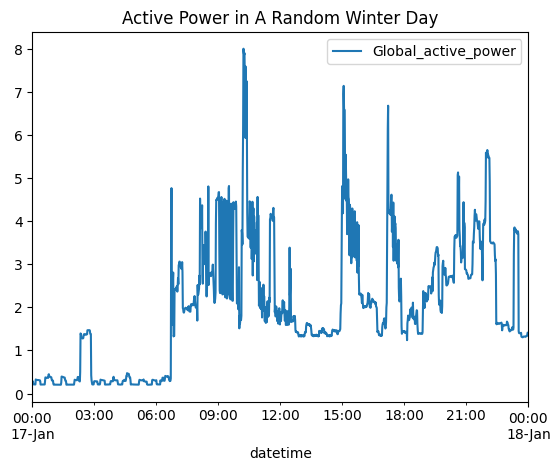

In [18]:
plot_ts(df=data_train,col='Global_active_power',start_datetime='2007-01-17 00:00:00',
        end_datetime='2007-01-18 00:00:00',title="Active Power in A Random Winter Day",
        save_location=localpath.figures.value)

Day plot(in Summer):

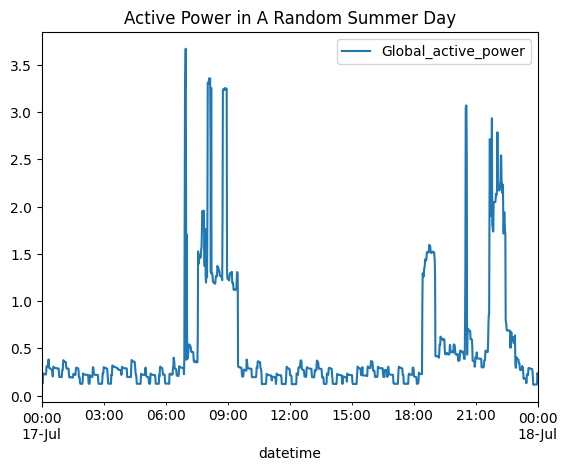

In [19]:
plot_ts(df=data_train,col='Global_active_power',start_datetime='2007-07-17 00:00:00',
        end_datetime='2007-07-18 00:00:00',title="Active Power in A Random Summer Day",
        save_location=localpath.figures.value)

One Week plot:

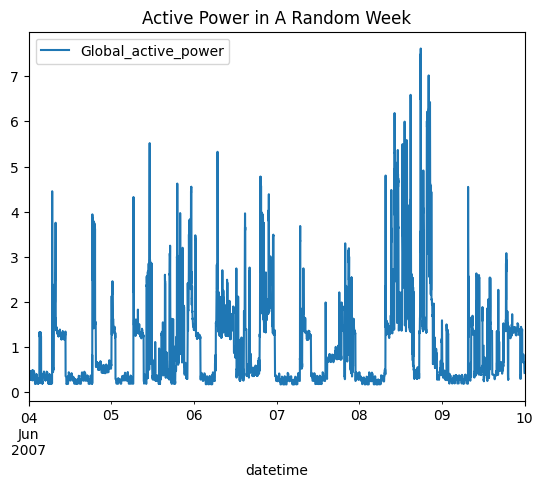

In [20]:
plot_ts(df=data_train,col='Global_active_power',start_datetime='2007-06-04 00:00:00',
        end_datetime='2007-06-10 00:00:00',title="Active Power in A Random Week",
        save_location=localpath.figures.value)

**Comments**: 
- On both summer and winter, people tend to use electricity starting from 7:00AM. This is the regular and expected behavior taking into account the basic human sleep cycle.
- In summer, the peak usage is between 6:00AM and 9:00 AM (Bedore people leave home).
- In Winter, he peak usage is between 9:00AM and 6:00 PM.

### Voltage

Day plot(in winter):

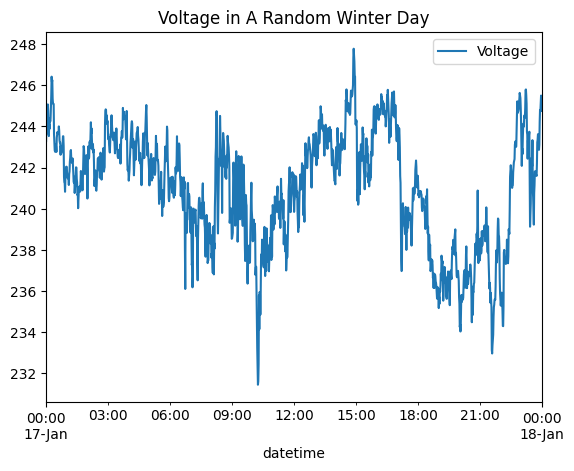

In [21]:
plot_ts(df=data_train,col='Voltage',start_datetime='2007-01-17 00:00:00',
        end_datetime='2007-01-18 00:00:00',title="Voltage in A Random Winter Day",
        save_location=localpath.figures.value)

Day plot(in Summer):

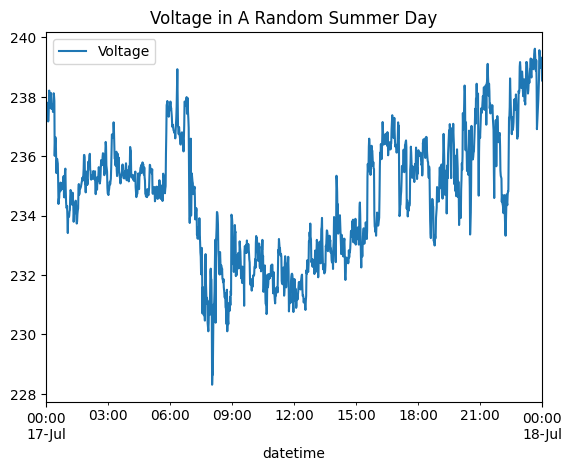

In [22]:
plot_ts(df=data_train,col='Voltage',start_datetime='2007-07-17 00:00:00',
        end_datetime='2007-07-18 00:00:00',title="Voltage in A Random Summer Day",
        save_location=localpath.figures.value)

One Week plot:

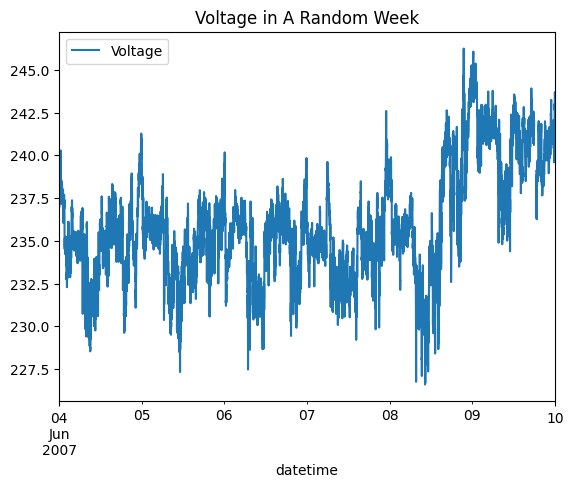

In [23]:
plot_ts(df=data_train,col='Voltage',start_datetime='2007-06-04 00:00:00',
        end_datetime='2007-06-10 00:00:00',title="Voltage in A Random Week",
        save_location=localpath.figures.value)

In [24]:
data_train.loc['2007-07-17 00:00:00':'2007-07-18 00:00:00','Voltage'].std()

2.142921014256072

In [25]:
data_train.loc['2007-01-17 00:00:00':'2007-01-18 00:00:00','Voltage'].std()

2.7820328320005663

**Comments**: 
- The Voltage is fluctating either in winter or in summer. The std is 2:3.

### Sub_metering_1 (Kitchen)

Day plot(in winter):

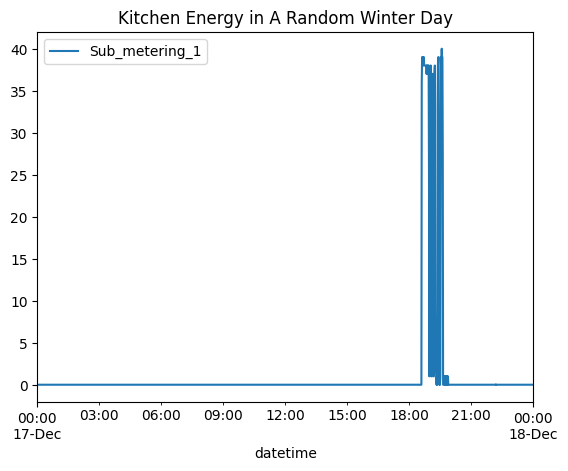

In [26]:
plot_ts(df=data_train,col='Sub_metering_1',start_datetime='2007-12-17 00:00:00',
        end_datetime='2007-12-18 00:00:00',title="Kitchen Energy in A Random Winter Day",
        save_location=localpath.figures.value)

Day plot(in Summer):

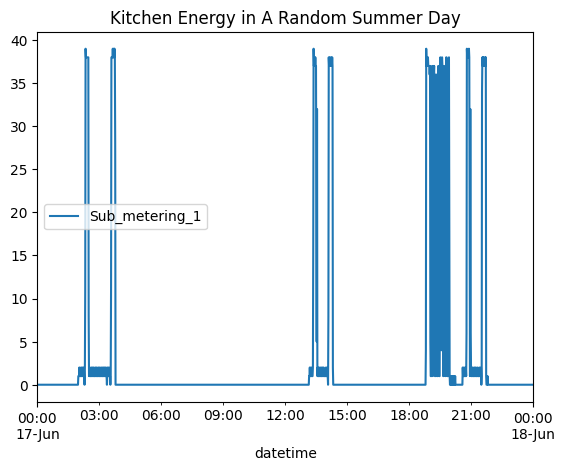

In [27]:
plot_ts(df=data_train,col='Sub_metering_1',start_datetime='2007-06-17 00:00:00',
        end_datetime='2007-06-18 00:00:00',title="Kitchen Energy in A Random Summer Day",
        save_location=localpath.figures.value)

One Week plot:

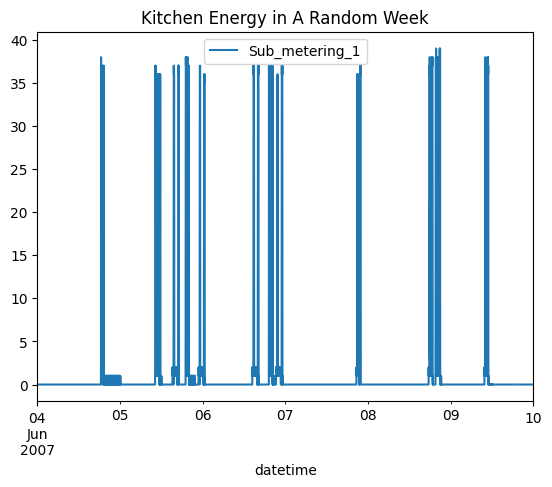

In [28]:
plot_ts(df=data_train,col='Sub_metering_1',start_datetime='2007-06-04 00:00:00',
        end_datetime='2007-06-10 00:00:00',title="Kitchen Energy in A Random Week",
        save_location=localpath.figures.value)

**Comments**: 
- People use the kitchen one to three times per day

### Sub_metering_2(laundry room)

Day plot(in winter):

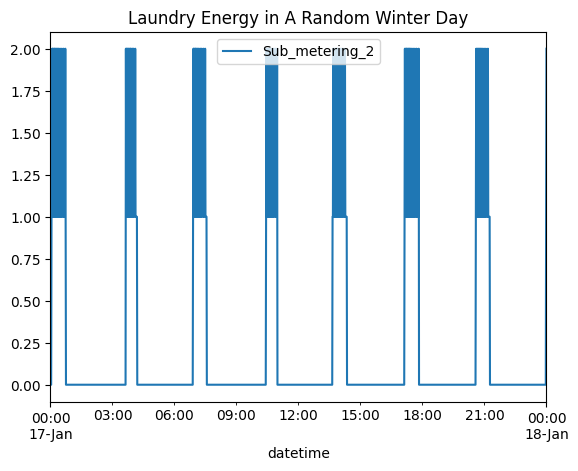

In [29]:
plot_ts(df=data_train,col='Sub_metering_2',start_datetime='2008-01-17 00:00:00',
        end_datetime='2008-01-18 00:00:00',title="Laundry Energy in A Random Winter Day",
        save_location=localpath.figures.value)

Day plot(in Summer):

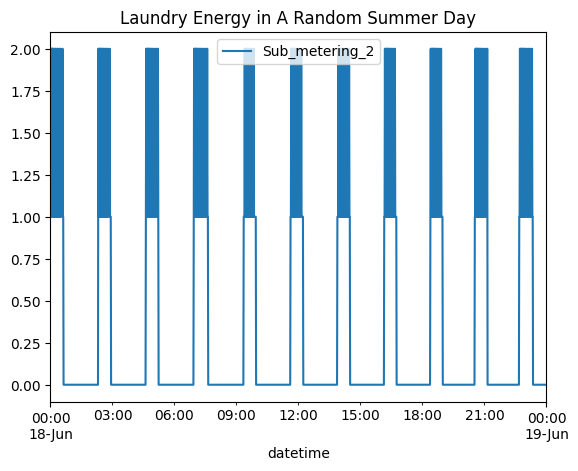

In [30]:
plot_ts(df=data_train,col='Sub_metering_2',start_datetime='2007-06-18 00:00:00',
        end_datetime='2007-06-19 00:00:00',title="Laundry Energy in A Random Summer Day",
        save_location=localpath.figures.value)

One Week plot:

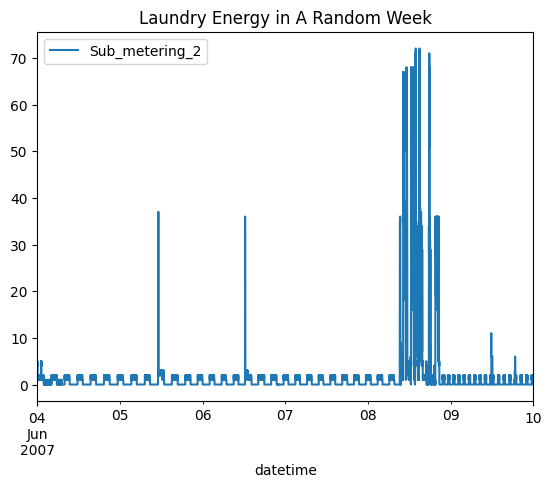

In [31]:
plot_ts(df=data_train,col='Sub_metering_2',start_datetime='2007-06-04 00:00:00',
        end_datetime='2007-06-10 00:00:00',title="Laundry Energy in A Random Week",
        save_location=localpath.figures.value)

**Comments**: 
- People use the laundry room almost every hour.

### Sub_metering_3(water-heater and A/C)

Day plot(in winter):

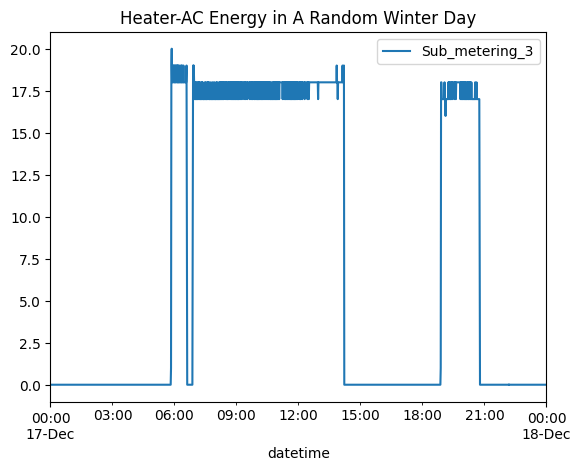

In [32]:
plot_ts(df=data_train,col='Sub_metering_3',start_datetime='2007-12-17 00:00:00',
        end_datetime='2007-12-18 00:00:00',title="Heater-AC Energy in A Random Winter Day",
        save_location=localpath.figures.value)

Day plot(in Summer):

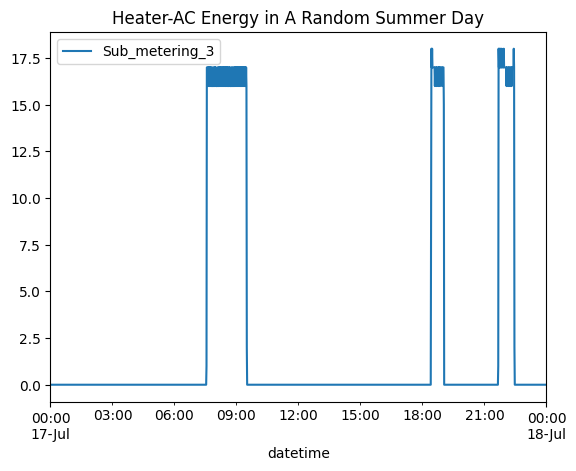

In [33]:
plot_ts(df=data_train,col='Sub_metering_3',start_datetime='2007-07-17 00:00:00',
        end_datetime='2007-07-18 00:00:00',title="Heater-AC Energy in A Random Summer Day",
        save_location=localpath.figures.value)

One Week plot:

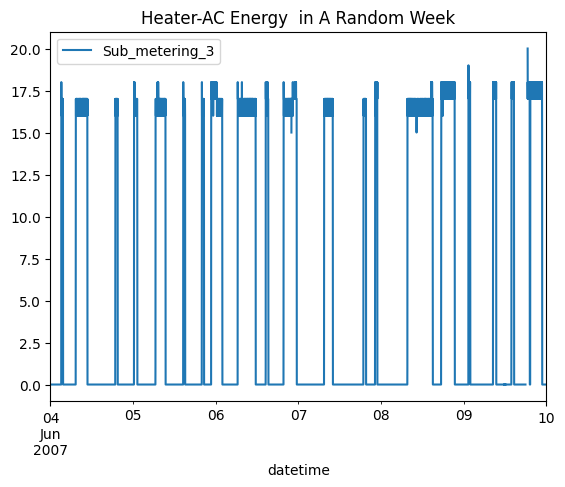

In [34]:
plot_ts(df=data_train,col='Sub_metering_3',start_datetime='2007-06-04 00:00:00',
        end_datetime='2007-06-10 00:00:00',title="Heater-AC Energy  in A Random Week",
        save_location=localpath.figures.value)

**Comments**: 
- In winter, cooling/heater energy is more used by the house. Which means, people tend to use heating equipment more than cooling. Or eaither, the energy required for heating is higher.

# 4. Data Preprocessing

## 4.1 Helper Classes / Functions


In [35]:
def split_series(data, window, steps):
    """splits the timeseries dataframe to a seequence of inputs/outputs

    Args:
        data (_type_): the dataframe containing timeseries variables
        window (_type_): The window to consider for prediction(past values)
        steps (_type_): The steps for predicition(future values)

    Returns:
        _type_: _description_
    """
    data= data.to_numpy()
    x, y = list(), list()
    for window_start in range(len(data)):
        past_end = window_start + window
        future_end = past_end + steps
        if future_end > len(data):
            break
        # slicing the data array to get past and future values
        past= data[window_start:past_end, :]
        x.append(past)
        future= data[past_end:future_end, :]
        y.append(future)

    # Converting to np ndarray
    x = np.array(x).astype('float32')
    y= np.array(y).astype('float32')
    return x,y

# 4.2 Downsampling the time series

In [36]:
#Downsampling of Data from minutes to Days
#There are more than 2 lakh observations recorded. Let’s make the data simpler by downsampling them from the frequency of minutes to days.

data_train = data_train.resample('D').sum()
data_test = data_test.resample('D').sum()
data_val = data_val.resample('D').sum()

**Comments**: 
- For prediction, day-based prediction will help the company understand energy usage more.
- Down sampling will help get red of missing values. This is not the best approach, missingness should have been analyzed and imputed in a more professional way.

## 4.3 Scaling

In [37]:
from sklearn.preprocessing  import MinMaxScaler
# Definition of the scaler
Scaler = MinMaxScaler(feature_range=(0, 1))
Scaler.set_output(transform = 'pandas')

#fitting the scaler on variables of the training dataset
Scaler.fit(data_train.astype(np.float64))

data_train = Scaler.transform(data_train.astype(np.float64));
data_val = Scaler.transform(data_val.astype(np.float64));
data_test= Scaler.transform(data_test.astype(np.float64));

In [38]:
with open(localpath.models.value+'/scaler.pickle', 'wb') as handle:
    pickle.dump(Scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

- It's better to include all the preprocessing steps in the model architecture it self. But this will require much work to ensure portability

## 4.5 feature Selection

We will rely on Deep networks ability to extract features.

## 4.6 Sequence Creation

In [39]:
window=3
steps=7
fratures=data_train.shape[1]

x_train,y_train=split_series(data_train,window,steps)
x_val,y_val=split_series(data_val,window,steps)
x_test,y_test=split_series(data_test,window,steps)

In [40]:
with open(localpath.data_processed.value+'/x_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(localpath.data_processed.value+'/y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(localpath.data_processed.value+'/x_val.pickle', 'wb') as handle:
    pickle.dump(x_val   , handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(localpath.data_processed.value+'/y_val.pickle', 'wb') as handle:
    pickle.dump(y_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(localpath.data_processed.value+'/x_test.pickle', 'wb') as handle:
    pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(localpath.data_processed.value+'/y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5. Modeling

## 5.1 Helper Classes / Functions

In [41]:
class MlflowCallback(tf.keras.callbacks.Callback):
    """A callback to log keras metrics in the mlflow server"""
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metric("loss", logs['loss'], step=epoch)
        mlflow.log_metric("accuracy", logs['accuracy'], step=epoch)
        if 'val_loss' in logs:
            mlflow.log_metric("val_loss", logs['val_loss'], step=epoch)
        if 'val_accuracy' in logs:
            mlflow.log_metric("val_accuracy", logs['val_accuracy'], step=epoch)

In [42]:
class LossPlotCallback(keras.callbacks.Callback):
    def on_train_begin(self,logs):
        %matplotlib qt
        self.epoch = 0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 8))
    def on_epoch_end(self, epoch, logs=None):
            self.epoch = epoch
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.accuracies.append(logs.get('accuracy'))
            self.val_accuracies.append(logs.get('val_accuracy'))
            self.plot_loss_acc()


    def on_train_end(self,logs):
        %matplotlib inline
        self.plot_loss_acc()
    def plot_loss_acc(self):
        self.axs[0].cla()
        self.axs[0].plot(range(self.epoch+1),self.losses,
                        linestyle = '-',color='green',
                        label = 'Training Loss' )
        self.axs[0].plot(range(self.epoch+1),self.val_losses,
                        linestyle = '--',color='blue',
                        label = 'Validation Loss' )          
        self.axs[0].set_title('Loss Plot')
        self.axs[0].set_xlabel('Epoch')
        self.axs[0].set_ylabel('Loss')
        self.axs[0].legend()

        self.axs[1].cla()
        self.axs[1].plot(range(self.epoch+1), self.accuracies,
                        linestyle = '-',color='green',
                        label = 'Training Accuracy' )
        self.axs[1].plot(range(self.epoch+1), self.val_accuracies,
                        linestyle = '--',color='blue',
                        label = 'Validation Accuracy' )          
        self.axs[1].set_title('Accuracy Plot')
        self.axs[1].set_xlabel('Epoch')
        self.axs[1].set_ylabel('Accuracy')
        self.axs[1].legend()

        self.fig.canvas.draw()
        plt.show(block = False)
        plt.pause(0.001)



## 5.2 Model Architecture

In [43]:
@keras.saving.register_keras_serializable()
class LSTMEncoder(keras.layers.Layer):
    """Subclasses a Keras layer class for the LSTM-based Encoder to encode time-series features
    
        Attributes:
            num_layers (int): number of LSTM layers
            num_units (list): A list containing the number of units per each layer respectively.
    """
    def __init__(self,num_layers:int,num_units:list):

        self._model_name = 'LSTMEncoder'
        super().__init__(name = self._model_name)
        self.num_units=num_units
        self.num_layers=num_layers
        
        # Define a container the proper encoder layers
        self._encoder_layers=[]
        for layer in range(self.num_layers-1):
            self._encoder_layers.append(keras.layers.LSTM(self.num_units[layer], return_sequences = True, return_state=True,dropout=0.5))
        self._encoder_layers.append(keras.layers.LSTM(self.num_units[-1], return_state=True))

   
    # def summary(self):
    #     """A custom summary that acts similar to the original summary method.
    #     This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model) 
    #     """
    #     x = keras.Input(shape=, dtype=tf.float64,name='Input(in summary fun)')
    #     model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self._model_name)
    #     return model.summary()
    
    
    def call(self,inputs):
        

    
        layers_state_h=[]
        layers_state_c=[]
        encoder_outputs= inputs
        for layer in self._encoder_layers:
            encoder_outputs, state_h, state_c =layer(encoder_outputs)
            layers_state_h.append(state_h)
            layers_state_c.append(state_c)
        return (encoder_outputs, layers_state_h, layers_state_c)
        

In [52]:
@keras.saving.register_keras_serializable()
class LSTMDecoder(keras.layers.Layer):
    """Subclasses a Keras layer class for the LSTM-based Decoder to predict time-series features
    
        Attributes:
            num_layers (int): number of LSTM layers
            num_units (list): A list containing the number of units per each layer respectively.
            steps (int): number of predicted future steps
            num_features (int): the number of features in each step
    """
    def __init__(self,num_layers:int,num_units:list,steps:int,num_features:int):
        """_summary_

        Args:
            num_layers (int): number of LSTM layers
            num_units (list): A list containing the number of units per each layer respectively.
            steps (int): number of predicted future steps
            num_features (int): the number of features in each step
        """        
        self._model_name = 'LSTMDecoder'
        super().__init__(name = self._model_name)
        self.num_units=num_units
        self.num_layers=num_layers
        self.steps=steps
        self.num_features=num_features
        # Define a container the proper encoder layers
        self._decoder_layers=[]
        # repeat the encoder output for each step
        self._decoder_layers.append(keras.layers.RepeatVector(self.steps))
        for layer in range(self.num_layers):
            self._decoder_layers.append(keras.layers.LSTM(self.num_units[layer], return_sequences = True, return_state=True))
        self._decoder_layers.append(keras.layers.TimeDistributed(tf.keras.layers.Dense(self.num_features)))
    
    # def summary(self):
    #     """A custom summary that acts similar to the original summary method.
    #     This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model) 
    #     """
    #     x = keras.Input(shape=(100,100), dtype=tf.float64,name='Input(in summary fun)')
    #     model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self._model_name)
    #     return model.summary()
  
    def call(self,inputs):
        # invoke the repeat vector layer
        decoder_outputs= self._decoder_layers[0](inputs[0])
        #invoke LSTM layers
        num_layers=len(self._decoder_layers)
        for i in range(1,num_layers-1):
            decoder_outputs, _, _ =self._decoder_layers[i](decoder_outputs,initial_state=(inputs[1][i-1],inputs[2][i-1]))   # i-1 because decoder has repeat vector while encoder doesn't
        # invoke the TimeDistributed layer
        output= self._decoder_layers[-1](decoder_outputs)
        
        return output

In [45]:
class Seq2SeqPredictor(keras.Model):
    """Subclasses a Keras layer model to wrap the encoder and decoder in one entity.

        Attributes:
            Encoder (keras.layers.Layer): a keras layer encabsulating the encoder
            Decoder (keras.layers.Layer): a keras layer encabsulating the decoder
            num_layers (int): number of LSTM layers
            num_units (list): A list containing the number of units per each layer respectively.
            steps (int): number of predicted future steps
            num_features (int): the number of features in each step
    """

    def __init__(self,Encoder:keras.layers.Layer,Decoder:keras.layers.Layer,steps,num_features,num_layers,num_units):
        """_summary_

        Args:
            Encoder (keras.layers.Layer): _description_
            Decoder (keras.layers.Layer): _description_
            num_Dense (int): _description_
            num_neurons (list): _description_
            dropout (list): _description_
            activations (list): _description_
        """        
        self.model_name = 'Seq2SeqPredictor'
        super().__init__(name = self.model_name)
        self.steps = steps
        self.num_features =num_features 
        self.num_layers = num_layers
        self.num_units = num_units

        self.Encoder = Encoder(num_layers,num_units)
        self.Decoder = Decoder(num_layers,num_units,steps,num_features)
    
    def summary(self):
        """A custom summary that acts similar to the original summary method.
        This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model) 
        """
        x = keras.Input(shape=(3,self.num_features), dtype=tf.float64,name='Input(in summary fun)')
        model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self.model_name)
        return model.summary()
    
    def call(self, inputs):
        x = inputs
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x
    
    # @classmethod
    # def from_config(cls, config):
    #     sublayer_config = config.pop("sublayer")
    #     sublayer = keras.saving.deserialize_keras_object(sublayer_config)
    #     return cls(sublayer, **config)

    
    def train_model(self, compile_kwargs:dict, fit_kwargs :dict, expirement_name:str=None, run_name:str=None):
        """trains a model while keeping track of expirement and model registery.

        Args:
            compile_kwargs (dict): Keyword Arguments for keras_model.compile()
            fit_kwargs (dict): Keyword Arguments for keras_model.fit()
            expirement_name (str, optional): The expirement name for the mlflow server. Defaults to None.
            run_name (str, optional): The run name for the mlflow server. Defaults to None.

        Returns:
            _type_: _description_
        """
        
        # If expirement or run names are not given, set to default
        if expirement_name:
            mlflow.set_experiment(expirement_name)
        else:
            mlflow.set_experiment()
        
        if run_name:
            run_name = run_name
        else:
            run_name = ""
        
        # fit the model while tracking model parameters and metrics
        with mlflow.start_run(run_name = run_name):
            #compile the model
            self.compile(**compile_kwargs)
            
            # log model parameters (either given or the defaults)
            mlflow.log_param("epochs", fit_kwargs['epochs'])
            mlflow.log_param("batch_size", fit_kwargs['batch_size'])
            mlflow.log_param("optimizer_name", self.optimizer.name)
            mlflow.log_param("optimizer_learning_rate", self.optimizer.learning_rate.numpy())
            mlflow.log_param("optimizer_beta_1", self.optimizer.beta_1)
            mlflow.log_param("optimizer_beta_2", self.optimizer.beta_2)
            mlflow.log_param("optimizer_epsilon", self.optimizer.epsilon)
            mlflow.log_param("loss_name", self.loss.name)
            
            # fit method callbacks
            mlflow_callback = MlflowCallback()         # to log in mlfow server
            plot_callback = LossPlotCallback()         # to draw the learning curves dynamically
            fit_kwargs['callbacks'] = [mlflow_callback,plot_callback]
            
            # fitting the model
            history = self.fit(**fit_kwargs)

            # Evaluate the model
            loss, accuracy = self.evaluate(fit_kwargs['x'],fit_kwargs['y'])
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("accuracy", accuracy)

            #log the validation metrics
            if 'validation_data' in fit_kwargs:
                validation_data = fit_kwargs['validation_data']
                val_loss, val_accuracy = self.evaluate(validation_data[0], validation_data[1])
                mlflow.log_metric("val_loss", val_loss)
                mlflow.log_metric("val_accuracy", val_accuracy)
                
        mlflow.end_run()
        return history
    

## 5.3 1st Expirement

### first run

2024-05-05 02:32:39.281115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 02:32:39.560420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 02:32:39.560487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 02:32:39.563339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 02:32:39.563381: I external/local_xla/xla/stream_executor

Epoch 1/100


2024-05-05 02:32:51.179567: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 02:33:06.382082: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-05 02:33:07.503402: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f23d0047b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-05 02:33:07.503478: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-05-05 02:33:07.581898: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714865587.795827  346395 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 [==============================] - 21s 39ms/step - loss: 0.1413 - accuracy: 0.8718 - val_loss: 0.0921 - val_accuracy: 0.9607
Epoch 2/100
72/72 [==============================] - 2s 23ms/step - loss: 0.0935 - accuracy: 0.9933 - val_loss: 0.0872 - val_accuracy: 0.9607
Epoch 3/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0915 - accuracy: 0.9933 - val_loss: 0.0899 - val_accuracy: 0.9607
Epoch 4/100
72/72 [==============================] - 1s 16ms/step - loss: 0.0903 - accuracy: 0.9933 - val_loss: 0.0849 - val_accuracy: 0.9607
Epoch 5/100
72/72 [==============================] - 1s 16ms/step - loss: 0.0900 - accuracy: 0.9933 - val_loss: 0.0842 - val_accuracy: 0.9607
Epoch 6/100
72/72 [==============================] - 1s 16ms/step - loss: 0.0893 - accuracy: 0.9933 - val_loss: 0.0859 - val_accuracy: 0.9607
Epoch 7/100
72/72 [==============================] - 2s 25ms/step - loss: 0.0896 - accuracy: 0.9933 - val_loss: 0.0846 - val_accuracy: 0.9607
Epoch 8/100
72/72

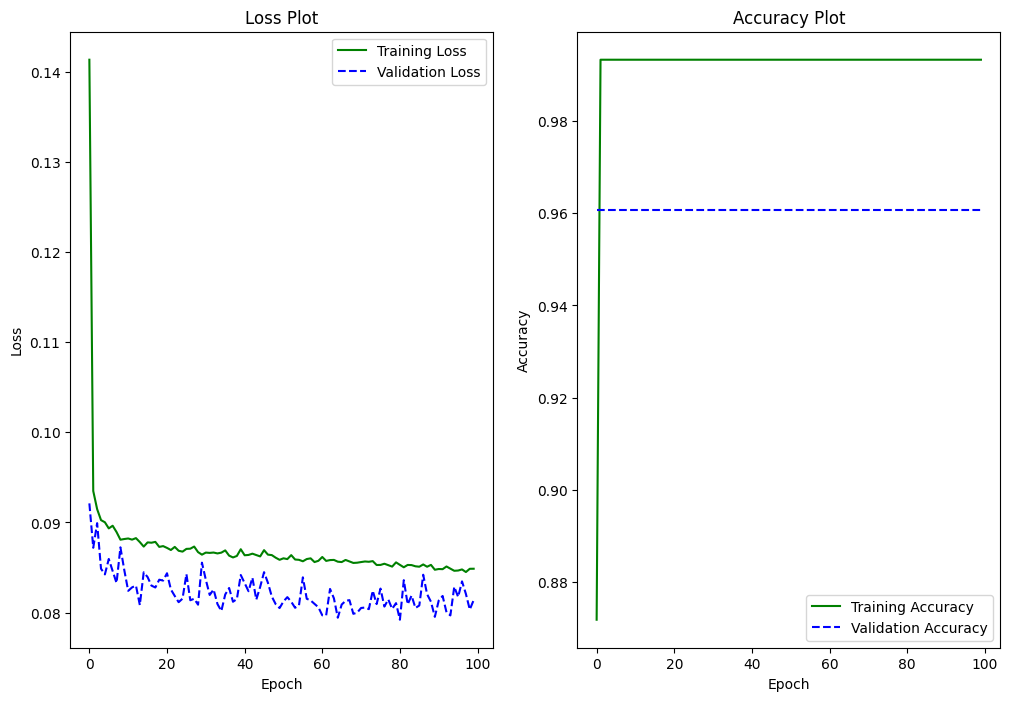

9/9 [==============================] - 0s 8ms/step - loss: 0.0814 - accuracy: 0.9607


In [46]:
model= Seq2SeqPredictor(Encoder=LSTMEncoder,Decoder=LSTMDecoder,steps=steps,
                        num_features=fratures,num_layers=1,num_units=[100])

compile_kwargs = { 'loss': keras.losses.MeanAbsoluteError () ,
                    'optimizer':keras.optimizers.Adam(learning_rate=0.001),
                    'metrics':['accuracy']}
                    
fit_kwargs = {'x': x_train, 'y' :y_train , 'validation_data' : (x_val,y_val),
               'epochs':100, 'batch_size' : 12,'shuffle':True}
model.train_model(compile_kwargs, fit_kwargs,expirement_name= 'Seq2seq-LSTM',run_name= '1layers-100units')

- The model results were very strange. It seems that the model is overfitting the trianing data. Also it is strange that the validation accuracy is constant.
- We may try simplifying the model

### second run

Epoch 1/25


72/72 [==============================] - 5s 45ms/step - loss: 0.1863 - accuracy: 0.6941 - val_loss: 0.1000 - val_accuracy: 0.9607
Epoch 2/25
72/72 [==============================] - 2s 32ms/step - loss: 0.0982 - accuracy: 0.9933 - val_loss: 0.0878 - val_accuracy: 0.9607
Epoch 3/25
72/72 [==============================] - 2s 21ms/step - loss: 0.0924 - accuracy: 0.9933 - val_loss: 0.0854 - val_accuracy: 0.9607
Epoch 4/25
72/72 [==============================] - 1s 18ms/step - loss: 0.0905 - accuracy: 0.9933 - val_loss: 0.0862 - val_accuracy: 0.9607
Epoch 5/25
72/72 [==============================] - 2s 22ms/step - loss: 0.0898 - accuracy: 0.9933 - val_loss: 0.0855 - val_accuracy: 0.9607
Epoch 6/25
72/72 [==============================] - 2s 22ms/step - loss: 0.0893 - accuracy: 0.9933 - val_loss: 0.0829 - val_accuracy: 0.9607
Epoch 7/25
72/72 [==============================] - 2s 27ms/step - loss: 0.0891 - accuracy: 0.9933 - val_loss: 0.0842 - val_accuracy: 0.9607
Epoch 8/25
72/72 [======

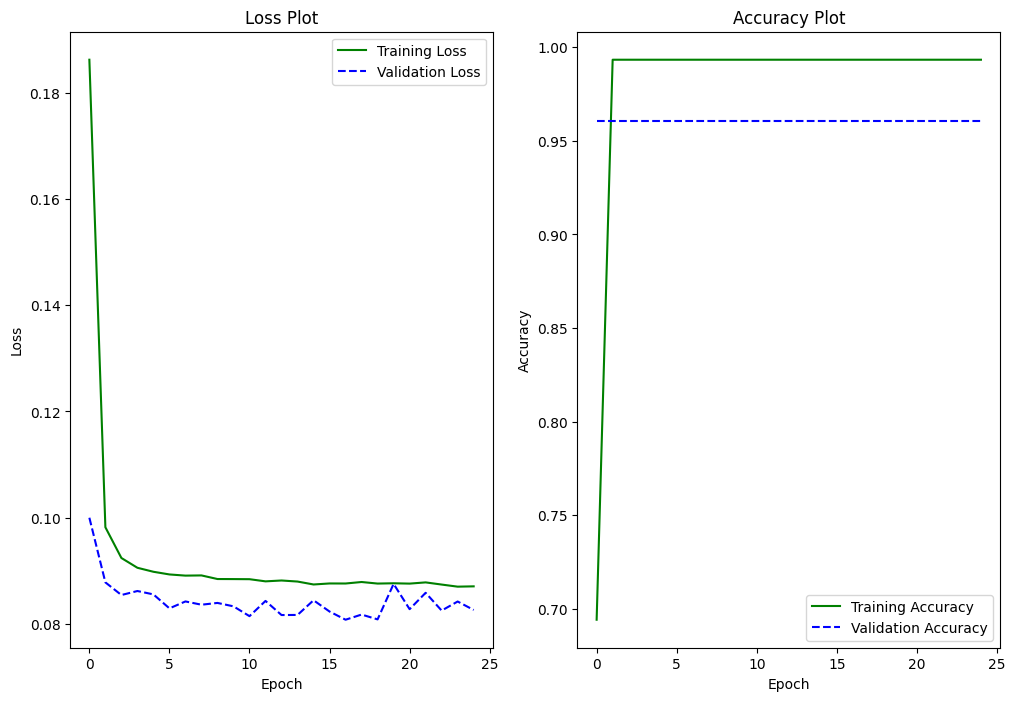

9/9 [==============================] - 0s 8ms/step - loss: 0.0826 - accuracy: 0.9607


In [47]:
model= Seq2SeqPredictor(Encoder=LSTMEncoder,Decoder=LSTMDecoder,steps=steps,
                        num_features=fratures,num_layers=1,num_units=[30])

compile_kwargs = { 'loss': keras.losses.MeanAbsoluteError () ,
                    'optimizer':keras.optimizers.Adam(learning_rate=0.001),
                    'metrics':['accuracy']}
                    
fit_kwargs = {'x': x_train, 'y' :y_train , 'validation_data' : (x_val,y_val),
               'epochs':25, 'batch_size' : 12,'shuffle':True}
model.train_model(compile_kwargs, fit_kwargs,expirement_name= 'Seq2seq-LSTM',run_name= '1layers-30units')

- Yet the loss curves doen't show overfitting, but the accuracy curves do. 
- Since the validation accuracy is constant while the validation loss is monotonically decreasing, this may mean the model is doing very well on some validation samples, and very bad on others.
- We may try to change the learning rate to overcome this.

### Third run

Epoch 1/25
72/72 [==============================] - 6s 53ms/step - loss: 0.3871 - accuracy: 0.0013 - val_loss: 0.3807 - val_accuracy: 5.1020e-04
Epoch 2/25
72/72 [==============================] - 3s 40ms/step - loss: 0.3486 - accuracy: 0.0012 - val_loss: 0.3419 - val_accuracy: 0.0015
Epoch 3/25
72/72 [==============================] - 4s 50ms/step - loss: 0.3072 - accuracy: 8.3347e-04 - val_loss: 0.2997 - val_accuracy: 0.0031
Epoch 4/25
72/72 [==============================] - 1s 20ms/step - loss: 0.2669 - accuracy: 3.3339e-04 - val_loss: 0.2644 - val_accuracy: 0.0041
Epoch 5/25
72/72 [==============================] - 2s 22ms/step - loss: 0.2350 - accuracy: 5.0008e-04 - val_loss: 0.2345 - val_accuracy: 0.0087
Epoch 6/25
72/72 [==============================] - 3s 45ms/step - loss: 0.2095 - accuracy: 0.1222 - val_loss: 0.2082 - val_accuracy: 0.3704
Epoch 7/25
72/72 [==============================] - 1s 18ms/step - loss: 0.1885 - accuracy: 0.6081 - val_loss: 0.1859 - val_accuracy: 0.67

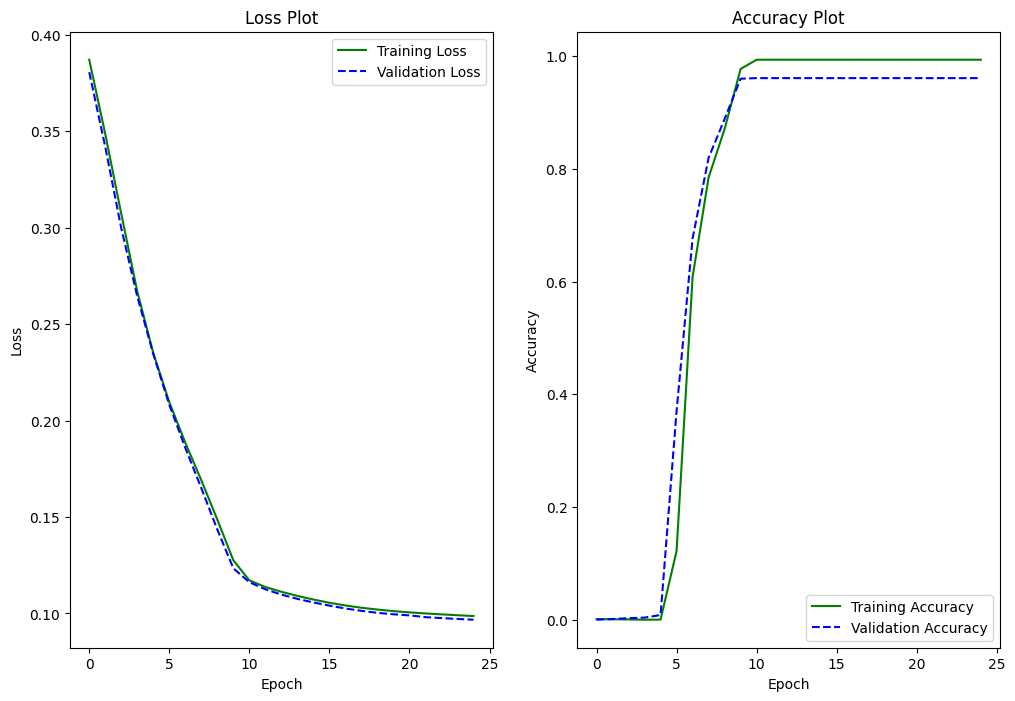

9/9 [==============================] - 0s 20ms/step - loss: 0.0968 - accuracy: 0.9607


In [48]:
model= Seq2SeqPredictor(Encoder=LSTMEncoder,Decoder=LSTMDecoder,steps=steps,
                        num_features=fratures,num_layers=1,num_units=[10])

compile_kwargs = { 'loss': keras.losses.MeanAbsoluteError () ,
                    'optimizer':keras.optimizers.Adam(learning_rate=0.0001),
                    'metrics':['accuracy']}
                    
fit_kwargs = {'x': x_train, 'y' :y_train , 'validation_data' : (x_val,y_val),
               'epochs':25, 'batch_size' : 12,'shuffle':True}
model.train_model(compile_kwargs, fit_kwargs,expirement_name= 'Seq2seq-LSTM',run_name= '1layer-10units-lrdecreased')

In [49]:
model.save_weights(localpath.models.value+'/seq2seq_lstm.weights')

# 6. Evaluation

In [50]:
def predict(scaler,model,input):
    scaled= model.predict(input)
    unscaled= scaler.inverse_transform(scaled)
    return unscaled


In [51]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 0s 28ms/step - loss: 0.0964 - accuracy: 0.9786


[0.09639252722263336, 0.9785714149475098]

- It's also important to plot each variable predictions. But due to the tight timeframe, this will be ignored.

# 7. Deployment


**Deployment Strategies**<br>

There are several ways to deploy the model, each with its strengths:

- **Stand-alone Application:** To develop a user-friendly application (using tools like Flask) that loads the trained model. Users can input historical data and receive predicted future consumption. This is a good option for initial testing and exploration by the energy company.
- **Cloud based:** Cloud platforms like Google Cloud AI Platform, Amazon SageMaker, or Microsoft Azure Machine Learning offer exciting possibilities:   
    - Scalability: Handle surges in prediction requests without issues.
    - Real-time Predictions: Integrate seamlessly with live data streams for on-the-fly forecasting.
    - API Access: Allow external applications to interact with the model using an API, opening up possibilities for wider integration.
    - Embedded Device Potential: Explore deploying a lightweight version of the model on an embedded device for scenarios where on-site predictions are needed (e.g., smart meters).


In [61]:


#create app
app = Flask(__name__)
# Load the model
model= Seq2SeqPredictor(Encoder=LSTMEncoder,Decoder=LSTMDecoder,steps=steps,
                        num_features=fratures,num_layers=1,num_units=[10])
model.load_weights(localpath.models.value+'/seq2seq_lstm.weights')

#load the preprocessor
file = open(localpath.models.value+'/scaler.pickle', 'rb')
data = pickle.load(file)
@app.route('/api',methods=['POST'])
def predict():
    # Get the data from the POST request.
    data = request.get_json(force=True)
    # Make prediction using model loaded from disk as per the data.
    prediction = model.predict(np.array(data))
    prediction= scaler.inverse_transform(prediction)
    # Take the first value of prediction
    output = prediction
    return jsonify(output)
if __name__ == '__main__':
    app.run(port=5000, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/ahmed/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ahmed/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/ahmed/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/home/ahmed/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/home/ahmed/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_

SystemExit: 1

/home/ahmed/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
